# I) General

## 1. Importations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import codecs
import re
import os.path
import random
import string
import re
import unicodedata
from time import time
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import sklearn.naive_bayes as nb

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

# II) First data set french presidents

## 1. Data visualization

In [2]:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8')
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

In [3]:
def preprocessing(X):
    res = []
    for doc in X:
        punc = string.punctuation
        punc += '\n\r\t'
        doc = doc.translate(str.maketrans(punc, ' ' * len(punc)))
        doc = unicodedata.normalize('NFD', doc).encode('ascii', 'ignore').decode("utf-8")
        doc = doc.lower()
        doc = re.sub('[0-9]+', '', doc)
        res.append(doc)
    return np.array(res)

def formal(X):
    stemmer = SnowballStemmer(language='french')
#     nltk.download('stopwords')
    res = []
    stop = stopwords.words('french')
    for doc in X:
        new_doc = ""
        for w in doc.split():
            if w not in stop:
                new_doc += w + " "
        new_doc = [stemmer.stem(X) for X in new_doc.split()]
        new_doc = " ".join(new_doc)
        res.append(new_doc)
    return res

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): 
            rt.extend(flatten(i))
        else: 
            rt.append(i)
    return rt

In [4]:
fname = "../TME1/data/corpus.tache1.learn.utf8"
alltxts, alllabs = load_pres(fname)
X = np.array(alltxts)[:1000]
Y = np.array(alllabs)[:1000]
X_preprocess = preprocessing(X)
X_train = formal(X_preprocess)

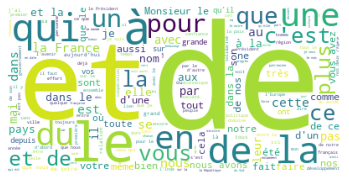

In [5]:
words = "".join(flatten(X))
wordcloud = WordCloud(background_color='white', max_words=200).generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

[9.99995000e-06 9.99995000e-06 9.99995000e-06 ... 6.56948143e+00
 6.72022017e+00 7.12689082e+00]
['insiste' 'malabar' 'malentendus' ... 'et' 'la' 'de']


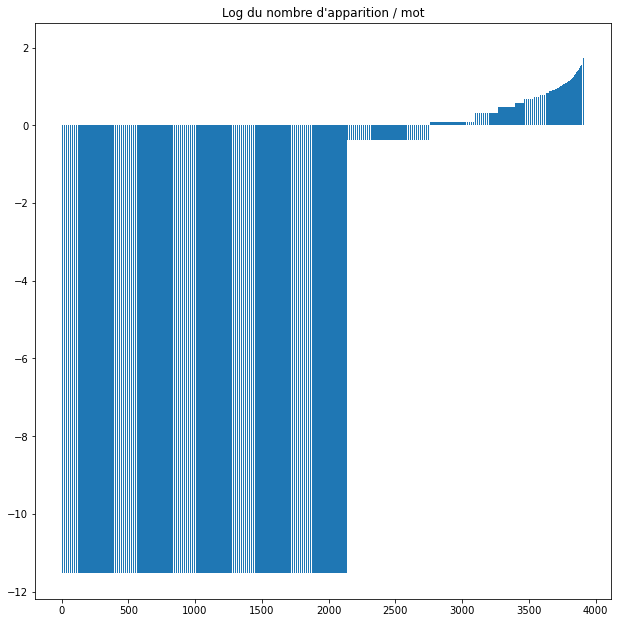

In [6]:
words = "".join(flatten(X_preprocess))
unique_words, count = np.unique(words.split(), return_counts=True)
count = np.log(count+1e-5)

count_sort_ind = np.argsort(count)
unique_words = unique_words[count_sort_ind]
count = np.sort(count)
print(count)
print(unique_words)

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(count)),np.log(count))
plt.title("Log du nombre d'apparition / mot")
plt.show()

[   1    1    1 ...  713  829 1245]
['insiste' 'malabar' 'malentendus' ... 'et' 'la' 'de']


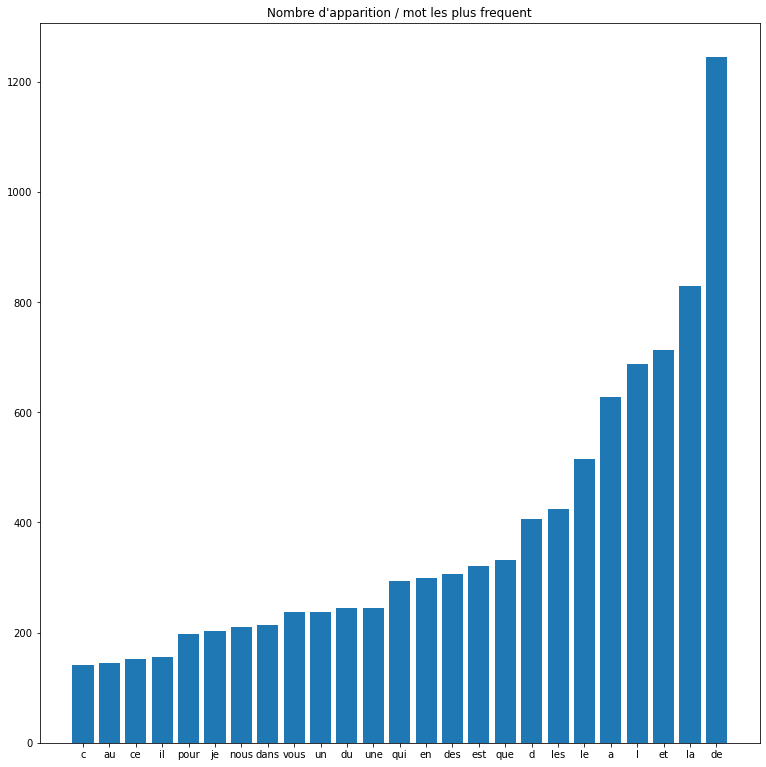

In [7]:
unique_words, count = np.unique(words.split(), return_counts=True)

count_sort_ind = np.argsort(count)
unique_words = unique_words[count_sort_ind]
count = np.sort(count)
print(count)
print(unique_words)

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(unique_words[len(count)-25:],count[len(count)-25:])
plt.title("Nombre d'apparition / mot les plus frequent")
plt.show()

## 2. Features and model selection

In [8]:
def naive_balancing(X, Y):
    label, count = np.unique(Y, return_counts=True)
    idx_pos = np.where(Y == 1, True, False)
    Y_pos = Y[idx_pos]
    Y_pos = Y_pos[:count.min()]
    idx_neg = np.where(Y == -1, True, False)
    Y_neg = Y[idx_neg]
    new_Y = np.concatenate((Y_pos, Y_neg))
    new_X = np.concatenate((X[:count.min()], X[idx_neg]))    
    tmp = list(zip(new_X, new_Y))
    random.shuffle(tmp)
    new_X, new_Y = zip(*tmp)  
    label, count = np.unique(new_Y, return_counts=True)
    print(label, count)
    return new_X, new_Y

def get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer, transformer=None):
    X_vector = vectorizer.fit_transform(X)
    if transformer is not None:
        transformer = transformer.fit(X_vector)
        X_final = transformer.transform(X_vector)
    else:
        X_final = X_vector
    X_test_vector = vectorizer.transform(X_test)
    return X_final, X_test_vector, Y, Y_test

def get_inf_acc(predictions, Y_test):
    idx_inf = np.where(predictions==-1, True, False)
    tmp_pred = predictions[idx_inf]
    tmp_real = Y_test[idx_inf]
    cpt = 0
    for i in range(len(tmp_pred)):
        if tmp_pred[i] == tmp_real[i]:
            cpt += 1
    return np.round((cpt/len(tmp_pred))*100, 2)

def get_sup_acc(predictions, Y_test):
    idx_inf = np.where(predictions==1, True, False)
    tmp_pred = predictions[idx_inf]
    tmp_real = Y_test[idx_inf]
    cpt = 0
    for i in range(len(tmp_pred)):
        if tmp_pred[i] == tmp_real[i]:
            cpt += 1
    return np.round((cpt/len(tmp_pred))*100, 2)

def display_infos(clf, X_test, Y_test):
    # Check le nombre de predictions pour chaque label
    predictions = clf.predict(X_test)
    unique, counts = np.unique(predictions, return_counts=True)
    print("/!\ Prediction counts for label ", unique, " --> ", counts)
    # Check le nombre de predictions pour chaque label
    unique, counts = np.unique(Y_test, return_counts=True)
    print("/!\ Ground truth counts for label ", unique, " --> ", counts)
    # Check la precision du label en inferiorite
    acc = get_inf_acc(predictions, Y_test)
    print("/!\ Accuracy of inferior label :", acc, "%")
    # Check la precision du label en superiorite
    acc = get_sup_acc(predictions, Y_test)
    print("/!\ Accuracy of superior label :", acc, "%\n")
    
def display_model_scores(model, X_test, Y_test, search=True):
    if search:
        best_parameters = model.best_estimator_.get_params()
        for param_name in sorted(best_parameters.keys()):
            print("--->%s: %r" % (param_name, best_parameters[param_name]))
        # print(model.best_score_)
    grid_predictions = model.predict(X_test)
    print(confusion_matrix(Y_test, grid_predictions))
    print(classification_report(Y_test, grid_predictions))
    
def stemm(X):
    stemmer = SnowballStemmer("french")
    stem = stemmer.stem(X)
    return X

### --> Loading and splitting data

In [9]:
fname = "../TME1/data/corpus.tache1.learn.utf8"
alltxts, alllabs = load_pres(fname)
X = np.array(alltxts)
Y = np.array(alllabs)
# new_X, new_Y = naive_balancing(X,Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False) # Test avec new_X, new_Y
train_size = len(X_train)
test_size = len(X_test)
print(train_size)
print(test_size)

45930
11483


### --> Stemming

In [10]:
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)
# for i in range(len(X_test)):
#     stemmer.stemWords(X_test[i].split()[j] for j in range(len(X_test[i].split())))

### --> Feature selection depending the model selected

In [11]:
search = False
sw = stopwords.words('french')

if search :
    
    # pipeline_svc = Pipeline(
    #     [
    #         ("vect", TfidfVectorizer(max_features=50_000)), # avoids overfit on train set (having more features than individuals is bad most of the time)
    #         ("clf", LinearSVC(class_weight="balanced", # balanced class weight parameter is mandatory in our case
    #                           max_iter=1000, # also avoids overfit
    #                           C=100)) # regularization so the model doesn't predict only one class  
    #     ]
    # )
    # pipeline_nb = Pipeline(
    #     [
    #         ("vect", TfidfVectorizer(max_features=80_000)),
    #         ("clf", MultinomialNB())      
    #     ]
    # )
    pipeline_lr = Pipeline(
        [
            ("vect", TfidfVectorizer(max_features=50_000)),
            ("clf", LogisticRegression(class_weight="balanced",
                                       max_iter=1000,
                                       C=100))        
        ]
    )
    parameters_vectorizer = {
        "vect__lowercase": (False,),
        "vect__stop_words": (None,),
        "vect__strip_accents": ("ascii",),
        "vect__use_idf": (True,False),
        "vect__smooth_idf": (False,True),
        "vect__sublinear_tf": (False,True),
        
        "vect__min_df": (1,),
        "vect__max_df": (0.50,),
        "vect__ngram_range": [(1, 2)],
        }
    
    strat_kfold = StratifiedKFold(n_splits=3, shuffle=True)

    # grid_search_parameters_svc = GridSearchCV(pipeline_svc, 
    #                                           parameters_vectorizer, 
    #                                           scoring="f1", # test "rog_auc"
    #                                           n_jobs=8, 
    #                                           verbose=3, 
    #                                           cv=strat_kfold,
    #                                           refit=True
    #                                           )
    # grid_search_parameters_nb = GridSearchCV(pipeline_nb, 
    #                                           parameters_vectorizer, 
    #                                           scoring="f1",
    #                                           n_jobs=8, 
    #                                           verbose=3, 
    #                                           cv=strat_kfold,
    #                                           refit=True
    #                                           )
    grid_search_parameters_lr = GridSearchCV(pipeline_lr, 
                                              parameters_vectorizer, 
                                              scoring="f1", 
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    
    # print("============================================= SVC + VECTORIZER =============================================")
    # t0 = time()
    # grid_search_parameters_svc.fit(X_train, Y_train)
    # print("done in %0.3fs" % (time() - t0))
    # display_model_scores(grid_search_parameters_svc, X_train, Y_train) # check overfit X_train
    # display_model_scores(grid_search_parameters_svc, X_test, Y_test)
    
#     print("============================================= NB + VECTORIZER =============================================")
#     t0 = time()
#     grid_search_parameters_nb.fit(X_train, Y_train)
#     print("done in %0.3fs" % (time() - t0))
#     display_model_scores(grid_search_parameters_nb, X_train, Y_train)
#     display_model_scores(grid_search_parameters_nb, X_test, Y_test) 
    
    print("============================================= LR + VECTORIZER =============================================")
    t0 = time()
    grid_search_parameters_lr.fit(X_train, Y_train)
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_lr, X_train, Y_train)
    display_model_scores(grid_search_parameters_lr, X_test, Y_test) 

In [12]:
# display_model_scores(grid_search_parameters_svc, X_test, Y_test)
# display_model_scores(grid_search_parameters_nb, X_test, Y_test)
# display_model_scores(grid_search_parameters_lr, X_test, Y_test)

### --> Building optimal vectorizer for each model

In [13]:
vectorizer_svc = TfidfVectorizer(lowercase=False,       # Almost false everytime in our case
                                 stop_words=None,       # Never remove stopwords
                                 strip_accents="ascii", # Sometimes none sometimes ascii, doesn't really matter
                                 use_idf=True,          # Always true
                                 smooth_idf=False,      # Sometimes true sometimes false, doesn't really matter
                                 sublinear_tf=True,     # Sometimes true sometimes false, doesn't really matter
                             
                                 max_features=50_000,   # Avoids overfit and reduce noise
                                 min_df=1,              # Always 1, meaning we don't remove anything
                                 max_df=0.79,           # One of the most meaningful parameters, can be 0.05, 0.9 ...
                                 ngram_range=(1,2),     # Always unigram + bigram
                                 )

vectorizer_nb = TfidfVectorizer(lowercase=False,
                                stop_words=None,
                                strip_accents=None,
                                # use_idf=True,
                                # smooth_idf=True,
                                # sublinear_tf=False,
                             
                                max_features=80_000,
                                min_df=15,
                                max_df=0.05,
                                ngram_range=(1,2),
                                )

vectorizer_lr = TfidfVectorizer(lowercase=False,
                                stop_words=None,
                                strip_accents="ascii",
                                use_idf=True,
                                smooth_idf=False,
                                sublinear_tf=False, # true ?
                             
                                max_features=50_000,
                                min_df=1,
                                max_df=0.5, # 0.05 ?
                                ngram_range=(1,2),
                                )

# Remove comment for stemming
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)

X_train_vector_svc, X_test_vector_svc, Y_train_svc, Y_test_svc = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_svc)
print(X_train_vector_svc.shape)
X_train_vector_nb, X_test_vector_nb, Y_train_nb, Y_test_nb = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_nb)
print(X_train_vector_nb.shape)
X_train_vector_lr, X_test_vector_lr, Y_train_lr, Y_test_lr = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_lr)
print(X_train_vector_lr.shape)

(45930, 50000)
(45930, 12920)
(45930, 50000)


### --> Model selection SVC

In [14]:
search = False
if search:
    parameters = {
        'C': np.arange(1,1.2,0.05) # according to our vectorizing parameters, this parameter doesn't matter a lot   
    }                              # but with other parameters it can take values around ~ 100
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_svc = GridSearchCV(LinearSVC(class_weight="balanced",
                                         max_iter=2000),
                               parameters, 
                               scoring="f1",
                               n_jobs=8, 
                               verbose=3, 
                               cv=strat_kfold,
                               refit=True
                               )

    t0 = time()
    optimal_svc.fit(X_train_vector_svc, Y_train_svc)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_svc, X_train_vector_svc, Y_train_svc)
    display_model_scores(optimal_svc, X_test_vector_svc, Y_test_svc)

### --> Model selection NB

In [15]:
search = False
if search:
    parameters = {
        'alpha': np.arange(0, 1, 0.05),
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_nb = GridSearchCV(MultinomialNB(),
                              parameters, 
                              scoring="f1",
                              n_jobs=8, 
                              verbose=3, 
                              cv=strat_kfold,
                              refit=True
                              )

    t0 = time()
    optimal_nb.fit(X_train_vector_nb, Y_train_nb)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_nb, X_train_vector_nb, Y_train_nb)
    display_model_scores(optimal_nb, X_test_vector_nb, Y_test_nb)

### --> Model selection LR

In [16]:
search = False
if search:
    parameters = {
        'C': (40,44,46) 
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_lr = GridSearchCV(LogisticRegression(class_weight="balanced",
                                                      max_iter=2000),
                               parameters, 
                               scoring="f1",
                               n_jobs=8, 
                               verbose=3, 
                               cv=strat_kfold,
                               refit=True
                               )

    t0 = time()
    optimal_lr.fit(X_train_vector_lr, Y_train_lr)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_lr, X_train_vector_lr, Y_train_lr)
    display_model_scores(optimal_lr, X_test_vector_lr, Y_test_lr)

### --> Test 3 optimal models without max_iter

In [17]:
final_svc = LinearSVC(class_weight="balanced",
                      max_iter=10_000,
                      C=1.15)

t0 = time()
final_svc.fit(X_train_vector_svc, Y_train_svc)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_svc, X_train_vector_svc, Y_train_svc, search=False)
display_model_scores(final_svc, X_test_vector_svc, Y_test_svc, search=False)

done in 0.743s
[[ 6355     5]
 [  533 39037]]
              precision    recall  f1-score   support

          -1       0.92      1.00      0.96      6360
           1       1.00      0.99      0.99     39570

    accuracy                           0.99     45930
   macro avg       0.96      0.99      0.98     45930
weighted avg       0.99      0.99      0.99     45930

[[ 750  413]
 [ 901 9419]]
              precision    recall  f1-score   support

          -1       0.45      0.64      0.53      1163
           1       0.96      0.91      0.93     10320

    accuracy                           0.89     11483
   macro avg       0.71      0.78      0.73     11483
weighted avg       0.91      0.89      0.89     11483



In [18]:
final_nb = MultinomialNB(alpha=0.1)

t0 = time()
final_nb.fit(X_train_vector_nb, Y_train_nb)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_nb, X_train_vector_nb, Y_train_nb, search=False)
display_model_scores(final_nb, X_test_vector_nb, Y_test_nb, search=False)

done in 0.008s
[[ 2849  3511]
 [  452 39118]]
              precision    recall  f1-score   support

          -1       0.86      0.45      0.59      6360
           1       0.92      0.99      0.95     39570

    accuracy                           0.91     45930
   macro avg       0.89      0.72      0.77     45930
weighted avg       0.91      0.91      0.90     45930

[[  411   752]
 [  207 10113]]
              precision    recall  f1-score   support

          -1       0.67      0.35      0.46      1163
           1       0.93      0.98      0.95     10320

    accuracy                           0.92     11483
   macro avg       0.80      0.67      0.71     11483
weighted avg       0.90      0.92      0.90     11483



In [19]:
final_lr = LogisticRegression(class_weight="balanced",
                              max_iter=10_000,
                              C=44)

t0 = time()
final_lr.fit(X_train_vector_lr, Y_train_lr)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_lr, X_train_vector_lr, Y_train_lr, search=False)
display_model_scores(final_lr, X_test_vector_lr, Y_test_lr, search=False)

done in 3.862s
[[ 6357     3]
 [  102 39468]]
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99      6360
           1       1.00      1.00      1.00     39570

    accuracy                           1.00     45930
   macro avg       0.99      1.00      1.00     45930
weighted avg       1.00      1.00      1.00     45930

[[ 727  436]
 [ 834 9486]]
              precision    recall  f1-score   support

          -1       0.47      0.63      0.53      1163
           1       0.96      0.92      0.94     10320

    accuracy                           0.89     11483
   macro avg       0.71      0.77      0.74     11483
weighted avg       0.91      0.89      0.90     11483



## 3. Final training on whole train dataset

In [20]:
fname = "../TME1/data/corpus.tache1.learn.utf8"
alltxts_train_final, alllabs_train_final = load_pres(fname)
X_train_final = np.array(alltxts_train_final)
Y_train_final = np.array(alllabs_train_final)

In [21]:
X_final_vector_svc = vectorizer_svc.fit_transform(X_train_final)
X_final_vector_nb = vectorizer_nb.fit_transform(X_train_final)
X_final_vector_lr = vectorizer_lr.fit_transform(X_train_final)

t0 = time()
final_svc.fit(X_final_vector_svc,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

t0 = time()
final_nb.fit(X_final_vector_nb,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

t0 = time()
final_lr.fit(X_final_vector_lr,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

 done in 0.908s
 done in 0.009s
 done in 5.381s


In [22]:
# display_model_scores(final_svc, X_final_vector_svc, Y_train_final, False)
# display_model_scores(final_nb, X_final_vector_nb, Y_train_final, False)
# display_model_scores(final_lr, X_final_vector_lr, Y_train_final, False)

## 4. Computing final test predicitons

In [23]:
fname = "../TME1/data/corpus.tache1.test.utf8"
alltxts_test_final, _ = load_pres(fname)
X_test_final = np.array(alltxts_test_final)

In [24]:
X_test_vector_svc = vectorizer_svc.transform(X_test_final)
final_pred_svc = final_svc.predict(X_test_vector_svc)

X_test_vector_nb = vectorizer_nb.transform(X_test_final)
final_pred_nb = final_nb.predict(X_test_vector_nb)

X_test_vector_lr = vectorizer_lr.transform(X_test_final)
final_pred_lr = final_lr.predict(X_test_vector_lr)

In [25]:
print(final_pred_svc.shape)
print(final_pred_nb.shape)
print(final_pred_lr.shape)

(27162,)
(27162,)
(27162,)


In [26]:
f = open("../TME1/output/preds_svc_noshuffle.txt", "a")
preds = ""
for i in range(len(final_pred_svc)):
    preds += str(final_pred_svc[i]) + "\n"
# print(preds)
f.write(preds)
f.close()

f = open("../TME1/output/preds_nb_noshuffle.txt", "a")
preds = ""
for i in range(len(final_pred_nb)):
    preds += str(final_pred_nb[i]) + "\n"
# print(preds)
f.write(preds)
f.close()

f = open("../TME1/output/preds_lr_noshuffle.txt", "a")
preds = ""
for i in range(len(final_pred_lr)):
    preds += str(final_pred_lr[i]) + "\n"
# print(preds)
f.write(preds)
f.close()

## 5. Post processing

### --> Train our best modele with our best vectorizer and check our f1 score before postprocessing

In [27]:
vectorizer_svc = TfidfVectorizer(lowercase=False,
                                 stop_words=None,
                                 strip_accents=None,
                                 # use_idf=True,
                                 # smooth_idf=True,
                                 # sublinear_tf=False,
                             
                                 max_features=50_000,
                                 min_df=1,
                                 max_df=0.5,
                                 ngram_range=(1,2),
                                 )

# Remove comment for stemming
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)

X_train_vector_svc, X_test_vector_svc, Y_train_svc, Y_test_svc = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_svc)
print(X_train_vector_svc.shape)
X_train_vector_lr, X_test_vector_lr, Y_train_lr, Y_test_lr = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_lr)
print(X_train_vector_lr.shape)

final_svc = LinearSVC(class_weight="balanced",
                      max_iter=10_000,
                      C=1.15)
final_lr = LogisticRegression(class_weight="balanced",
                              max_iter=10_000,
                              C=44)

t0 = time()
final_svc.fit(X_train_vector_svc, Y_train_svc)
print("done in %0.3fs" % (time() - t0))

t0 = time()
final_lr.fit(X_train_vector_lr, Y_train_lr)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_svc, X_test_vector_svc, Y_test_svc, search=False)
display_model_scores(final_lr, X_test_vector_lr, Y_test_lr, search=False)

(45930, 50000)
(45930, 50000)
done in 0.666s
done in 3.860s
[[ 755  408]
 [ 918 9402]]
              precision    recall  f1-score   support

          -1       0.45      0.65      0.53      1163
           1       0.96      0.91      0.93     10320

    accuracy                           0.88     11483
   macro avg       0.70      0.78      0.73     11483
weighted avg       0.91      0.88      0.89     11483

[[ 727  436]
 [ 834 9486]]
              precision    recall  f1-score   support

          -1       0.47      0.63      0.53      1163
           1       0.96      0.92      0.94     10320

    accuracy                           0.89     11483
   macro avg       0.71      0.77      0.74     11483
weighted avg       0.91      0.89      0.90     11483



### --> Preprocessing optimization functions

In [28]:
from tqdm import tqdm

def postprocessing(pred, window_size, Y_test, threshold):
    uni, cpt = np.unique(pred, return_counts=True)
    prob_mit = cpt[0]/len(pred)
    prob_chi = cpt[1]/len(pred)
    new_final_pred = np.zeros(len(pred))
    new_final_pred = pred.copy()
    new_final_pred = soft_smoothing(new_final_pred)
    new_final_pred = hard_smoothing(pred, new_final_pred, window_size, threshold)
    new_final_pred = soft_smoothing(new_final_pred)   
    return new_final_pred, f1_score(new_final_pred, Y_test)

# Smoothing values with a rolling window
def hard_smoothing(pred, new_final_pred, window_size, threshold):
    for i in range(window_size, len(new_final_pred) - window_size):
        neighbors = pred[int(i-window_size/2):int(i+window_size/2)] # Here we need to use pred and now new_final_pred_svc !!!
        unique, counts = np.unique(neighbors, return_counts=True)

        if len(unique) == 1:
            if unique[0] == 1:
                unique = np.append(unique,-1)
                counts = np.append(counts,0)
            else:
                unique = np.append(unique,1)
                counts = np.append(counts,0)
                
        # Probability smoothing learning
        if counts[0]/(counts[0]+counts[1]) > threshold: # This one seems useless after testing results
            new_final_pred[i] = int(unique[0])
        else:
            new_final_pred[i] = int(unique[1])
        if counts[1]/(counts[0]+counts[1]) > threshold: # Learning a threshold there instead of using prob_chi might be an error
            new_final_pred[i] = int(unique[1])
        else:
            new_final_pred[i] = int(unique[0])
                        
        # Probability smoothing with probs
        # if counts[0]/(counts[0]+counts[1]) > prob_mit: # This one seems useless after testing results
        #     new_final_pred[i] = int(unique[0])
        # else:
        #     new_final_pred[i] = int(unique[1])
        # if counts[1]/(counts[0]+counts[1]) > prob_chi: # Learning a threshold there instead of using prob_chi might be an error
        #     new_final_pred[i] = int(unique[1])
        # else:
        #     new_final_pred[i] = int(unique[0])
        
    return new_final_pred

# Smoothing solo values
def soft_smoothing(new_final_pred_svc):
    for i in range(1, len(new_final_pred_svc)-1):
        if (new_final_pred_svc[i-1] == -1 and new_final_pred_svc[i+1] == -1):
            new_final_pred_svc[i] = -1
        elif (new_final_pred_svc[i-1] == 1 and new_final_pred_svc[i+1] == 1):
            new_final_pred_svc[i] = 1
    return new_final_pred_svc

def optimize_postprocessing(preds, Y_test_svc):
    maxi = 0
    for window_size in tqdm(range(9,11,1)):
        for threshold in np.arange(0,1,0.1):
            new_preds, score = postprocessing(preds, window_size, Y_test_svc, threshold)
            if score > maxi:
                print("Update score :", score, "for ws:", window_size, "and threshold:", threshold)
                maxi = score
                best_ws = window_size
                best_thresh = threshold
                best_preds = new_preds
    return maxi, best_ws, best_thresh, best_preds

def final_postprocessing(pred, window_size, threshold):
    uni, cpt = np.unique(pred, return_counts=True)
    prob_mit = cpt[0]/len(pred)
    prob_chi = cpt[1]/len(pred)
    new_final_pred = np.zeros(len(pred))
    new_final_pred = pred.copy()
    new_final_pred = soft_smoothing(new_final_pred)
    new_final_pred = hard_smoothing(pred, new_final_pred, window_size, threshold)
    new_final_pred = soft_smoothing(new_final_pred)
    return new_final_pred

## 6. Computing final test predictions after postprocessing

### --> Find our best model for the smoothing

In [29]:
final_model = final_svc
X_test_vector_final = X_test_vector_svc
Y_test_final = Y_test_svc

maxi, best_ws, best_thresh, best_preds = optimize_postprocessing(final_model.predict(X_test_vector_final), Y_test_final) 

  0%|          | 0/2 [00:00<?, ?it/s]

Update score : 0.9478760045924225 for ws: 9 and threshold: 0.0
Update score : 0.9523370091819314 for ws: 9 and threshold: 0.2
Update score : 0.9594380872639315 for ws: 9 and threshold: 0.30000000000000004
Update score : 0.9680635906119186 for ws: 9 and threshold: 0.4
Update score : 0.9743785485948758 for ws: 9 and threshold: 0.5


 50%|█████     | 1/2 [00:02<00:02,  2.91s/it]

Update score : 0.9762350568918334 for ws: 10 and threshold: 0.5


100%|██████████| 2/2 [00:05<00:00,  2.87s/it]


### --> Displaying our f1 score after postprocessing

In [30]:
print("best parameters:", maxi, best_ws, best_thresh, best_preds)
print("------------------------------before------------------------------")
print(classification_report(final_model.predict(X_test_vector_final), Y_test_final))
print("------------------------------after------------------------------")
print(classification_report(best_preds, Y_test_final))

best parameters: 0.9762350568918334 10 0.5 [1 1 1 ... 1 1 1]
------------------------------before------------------------------
              precision    recall  f1-score   support

          -1       0.65      0.45      0.53      1673
           1       0.91      0.96      0.93      9810

    accuracy                           0.88     11483
   macro avg       0.78      0.70      0.73     11483
weighted avg       0.87      0.88      0.88     11483

------------------------------after------------------------------
              precision    recall  f1-score   support

          -1       0.71      0.84      0.77       974
           1       0.99      0.97      0.98     10509

    accuracy                           0.96     11483
   macro avg       0.85      0.91      0.87     11483
weighted avg       0.96      0.96      0.96     11483



### --> Results after postprocessing

In [31]:
print("------------------------------before------------------------------")
print(final_model.predict(X_test_vector_final)[:500])
print("------------------------------after------------------------------")
print(best_preds[:500])

------------------------------before------------------------------
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1  1 -1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1
 -1  1 -1  1 -1  1 -1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1
  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1

In [32]:
# We can get a better postprocessing because sometimes there is a missing value at the end or at the start
# SVC : 0.53 0.93 0.88 --> 0.76 0.98 0.95
# LR : 0.54 0.94 0.89 --> 0.75 0.98 0.94
# We chose SVC for our final predictions after postprocessing

In [33]:
fname = "../TME1/data/corpus.tache1.test.utf8"
alltxts_test_final, _ = load_pres(fname)
X_test_final = np.array(alltxts_test_final)

In [34]:
X_test_vector_svc = vectorizer_svc.transform(X_test_final)
final_pred_svc = final_svc.predict(X_test_vector_svc)

In [35]:
new_final_pred_svc = final_postprocessing(final_pred_svc, best_ws, best_thresh)

In [36]:
print(new_final_pred_svc.shape)

(27162,)


In [53]:
print(final_pred_svc[:500])
print(new_final_pred_svc[:500])

[ 1  1  1 -1 -1 -1 -1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1 -1  1  1  1  1  1 -1  1 -1 -1 -1  1  1  1 -1 -1  1 -1  1
  1 -1  1  1  1 -1  1 -1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1 -1  1 -1  1  1 -1  1 -1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1
  1 -1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1  1  1 -1 -1  1  1 -1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1

In [38]:
f = open("../TME1/output/preds_svc_no_shuffle_postprocess.txt", "a")
preds = ""
for i in range(len(new_final_pred_svc)):
    preds += str(new_final_pred_svc[i]) + "\n"
# print(preds)
f.write(preds)
f.close()

# III) Movie dataset

In [39]:
def load_movies(path2data): 
    alltxts = []
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): 
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 
    return alltxts,labs

## 1. Data visualization

## 2. Feature and model selection

### --> Loading and splitting data

In [40]:
path = "../TME1/data/movies1000/"
alltxts,alllabs = load_movies(path)
X = np.array(alltxts)
Y = np.array(alllabs)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
print(len(X_train))
print(len(X_test))

1600
400


### --> Stemming

In [41]:
# Remove comment for stemming
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)

### --> Feature selection depending the model selected

In [42]:
search = False
sw = stopwords.words('french')

if search :
    
    pipeline_svc = Pipeline(
        [
            ("vect", TfidfVectorizer(max_features=10_000)), # avoids overfit on train set (having more features than individuals is bad most of the time)
            ("clf", LinearSVC(max_iter=1000, # also avoids overfit
                              C=100)) # regularization so the model doesn't predict only one class  
        ]
    )
    pipeline_nb = Pipeline(
        [
            ("vect", TfidfVectorizer(max_features=10_000)),
            ("clf", MultinomialNB())      
        ]
    )
    pipeline_lr = Pipeline(
        [
            ("vect", TfidfVectorizer(max_features=10_000)),
            ("clf", LogisticRegression(max_iter=1000,
                                       C=100))        
        ]
    )
    parameters_vectorizer = {
        "vect__lowercase": (False,),
        "vect__stop_words": (None,),
        "vect__strip_accents": (None,),
        # "vect__use_idf": (True,False),
        # "vect__smooth_idf": (False,True),
        # "vect__sublinear_tf": (False,True),
        
        "vect__min_df": (1, 5, 15, 30),
        "vect__max_df": (0.01, 0.05, 0.1, 0.2, 0.5),
        "vect__ngram_range": [(1, 1), (1, 2)],
        }
    
    strat_kfold = StratifiedKFold(n_splits=3, shuffle=True)

    grid_search_parameters_svc = GridSearchCV(pipeline_svc, 
                                              parameters_vectorizer, 
                                              scoring="accuracy",
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    grid_search_parameters_nb = GridSearchCV(pipeline_nb, 
                                              parameters_vectorizer, 
                                              scoring="accuracy",
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    grid_search_parameters_lr = GridSearchCV(pipeline_lr, 
                                              parameters_vectorizer, 
                                              scoring="accuracy", 
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    
    print("============================================= SVC + VECTORIZER =============================================")
    t0 = time()
    grid_search_parameters_svc.fit(X_train, Y_train)
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_svc, X_train, Y_train) # check overfit X_train
    display_model_scores(grid_search_parameters_svc, X_test, Y_test)
    
    print("============================================= NB + VECTORIZER =============================================")
    t0 = time()
    grid_search_parameters_nb.fit(X_train, Y_train)
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_nb, X_train, Y_train)
    display_model_scores(grid_search_parameters_nb, X_test, Y_test) 
    
    print("============================================= LR + VECTORIZER =============================================")
    t0 = time()
    grid_search_parameters_lr.fit(X_train, Y_train)
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_lr, X_train, Y_train)
    display_model_scores(grid_search_parameters_lr, X_test, Y_test) 

### --> Building optimal vectorizer for each model

In [43]:
vectorizer_svc = TfidfVectorizer(lowercase=False,
                                 stop_words=None,
                                 strip_accents=None,
                                 # use_idf=True,
                                 # smooth_idf=True,
                                 # sublinear_tf=False,
                             
                                 max_features=10_000,
                                 min_df=5,
                                 max_df=0.5,
                                 ngram_range=(1,2),
                                 )

vectorizer_nb = TfidfVectorizer(lowercase=False,
                                stop_words=None,
                                strip_accents=None,
                                # use_idf=True,
                                # smooth_idf=True,
                                # sublinear_tf=False,
                             
                                max_features=10_000,
                                min_df=15,
                                max_df=0.1,
                                ngram_range=(1,2),
                                )

vectorizer_lr = TfidfVectorizer(lowercase=False,
                                stop_words=None,
                                strip_accents=None,
                                # use_idf=True,
                                # smooth_idf=True,
                                # sublinear_tf=False,
                             
                                max_features=10_000,
                                min_df=5,
                                max_df=0.5,
                                ngram_range=(1,2),
                                )

# Remove comment for stemming
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)

X_train_vector_svc, X_test_vector_svc, Y_train_svc, Y_test_svc = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_svc)
print(X_train_vector_svc.shape)
X_train_vector_nb, X_test_vector_nb, Y_train_nb, Y_test_nb = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_nb)
print(X_train_vector_nb.shape)
X_train_vector_lr, X_test_vector_lr, Y_train_lr, Y_test_lr = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_lr)
print(X_train_vector_lr.shape)

(1600, 10000)
(1600, 10000)
(1600, 10000)


### --> Model selection SVC

In [44]:
search = False
if search:
    parameters = {
        'C': (1,10,50,100,200,500)    
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_svc = GridSearchCV(LinearSVC(class_weight="balanced",
                                         max_iter=2000),
                               parameters, 
                               scoring="f1",
                               n_jobs=8, 
                               verbose=3, 
                               cv=strat_kfold,
                               refit=True
                               )

    t0 = time()
    optimal_svc.fit(X_train_vector_svc, Y_train_svc)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_svc, X_train_vector_svc, Y_train_svc)
    display_model_scores(optimal_svc, X_test_vector_svc, Y_test_svc)

### --> Model selection NB

In [45]:
if search:
    parameters = {
        'alpha': np.arange(0, 1, 0.05),
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_nb = GridSearchCV(MultinomialNB(),
                              parameters, 
                              scoring="f1",
                              n_jobs=8, 
                              verbose=3, 
                              cv=strat_kfold,
                              refit=True
                              )

    t0 = time()
    optimal_nb.fit(X_train_vector_nb, Y_train_nb)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_nb, X_train_vector_nb, Y_train_nb)
    display_model_scores(optimal_nb, X_test_vector_nb, Y_test_nb)

### --> Model selection LR

In [46]:
if search:
    parameters = {
        'C': (1, 10, 50, 100, 200, 500)
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_lr = GridSearchCV(LogisticRegression(class_weight="balanced",
                                                      max_iter=2000),
                               parameters, 
                               scoring="f1",
                               n_jobs=8, 
                               verbose=3, 
                               cv=strat_kfold,
                               refit=True
                               )

    t0 = time()
    optimal_lr.fit(X_train_vector_lr, Y_train_lr)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_lr, X_train_vector_lr, Y_train_lr)
    display_model_scores(optimal_lr, X_test_vector_lr, Y_test_lr)

### --> Test 3 optimal models without max_iter

In [47]:
final_svc = LinearSVC(class_weight="balanced",
                      max_iter=10_000,
                      C=10)

t0 = time()
final_svc.fit(X_train_vector_svc, Y_train_svc)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_svc, X_train_vector_svc, Y_train_svc, search=False)
display_model_scores(final_svc, X_test_vector_svc, Y_test_svc, search=False)

done in 0.226s
[[811   0]
 [  0 789]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       811
           1       1.00      1.00      1.00       789

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

[[152  37]
 [ 34 177]]
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       189
           1       0.83      0.84      0.83       211

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



In [48]:
final_nb = MultinomialNB(alpha=0.0)

t0 = time()
final_nb.fit(X_train_vector_nb, Y_train_nb)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_nb, X_train_vector_nb, Y_train_nb, search=False)
display_model_scores(final_nb, X_test_vector_nb, Y_test_nb, search=False)

done in 0.003s
[[781  30]
 [ 32 757]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       811
           1       0.96      0.96      0.96       789

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600

[[152  37]
 [ 43 168]]
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       189
           1       0.82      0.80      0.81       211

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



In [49]:
final_lr = LogisticRegression(class_weight="balanced",
                              max_iter=10_000,
                              C=100)

t0 = time()
final_lr.fit(X_train_vector_lr, Y_train_lr)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_lr, X_train_vector_lr, Y_train_lr, search=False)
display_model_scores(final_lr, X_test_vector_lr, Y_test_lr, search=False)

done in 0.202s
[[811   0]
 [  0 789]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       811
           1       1.00      1.00      1.00       789

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

[[156  33]
 [ 34 177]]
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       189
           1       0.84      0.84      0.84       211

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



## 3. Final training

In [50]:
path = "../TME1/data/movies1000/"
alltxts,alllabs = load_movies(path)
X = np.array(alltxts)
Y = np.array(alllabs)
X_train_final, X_test_final, Y_train_final, Y_test_final = train_test_split(X, Y, test_size=0.2, shuffle=True)
print(len(X_train))
print(len(X_test))

1600
400


In [51]:
X_final_vector_svc = vectorizer_svc.fit_transform(X_train_final)
X_final_vector_nb = vectorizer_nb.fit_transform(X_train_final)
X_final_vector_lr = vectorizer_lr.fit_transform(X_train_final)

X_test_vector_svc = vectorizer_svc.transform(X_test_final)
X_test_vector_nb = vectorizer_nb.transform(X_test_final)
X_test_vector_lr = vectorizer_lr.transform(X_test_final)

t0 = time()
final_svc.fit(X_final_vector_svc,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

t0 = time()
final_nb.fit(X_final_vector_nb,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

t0 = time()
final_lr.fit(X_final_vector_lr,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

 done in 0.214s
 done in 0.002s
 done in 0.278s


In [52]:
display_model_scores(final_svc, X_test_vector_svc, Y_test_final, search=False)
display_model_scores(final_nb, X_test_vector_nb, Y_test_final, search=False)
display_model_scores(final_lr, X_test_vector_lr, Y_test_final, search=False)

[[185  25]
 [ 27 163]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       210
           1       0.87      0.86      0.86       190

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400

[[172  38]
 [ 24 166]]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       210
           1       0.81      0.87      0.84       190

    accuracy                           0.84       400
   macro avg       0.85      0.85      0.84       400
weighted avg       0.85      0.84      0.85       400

[[184  26]
 [ 26 164]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       210
           1       0.86      0.86      0.86       190

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weigh